In [1]:
import sys

sys.path.append("../")

import time

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, precision_recall_curve
from tqdm import tqdm
from transformers import RobertaForSequenceClassification, RobertaTokenizer, Trainer, TrainingArguments

# Importing from the module
from src.bert import PayloadDataset, compute_metrics, load_and_preprocess_data

# Configuration
config = {
    "test_file": "../models/codebert/test/processed.parquet",
    "roberta_model": "../models/codebert/runs/2024-04-06_22-21-25",  # Point this to where your trained model is saved
    "tokenizer_path": "../models/codebert/runs/2024-04-06_22-21-25/",  # Point this to where your tokenizer is saved
    "training_args": {
        "per_device_eval_batch_size": 256,
        "logging_dir": "./logs",
    },
    "output_dir": "./results",
}

# Load pre-trained model and tokenizer
tokenizer = RobertaTokenizer.from_pretrained(config["tokenizer_path"])
model = RobertaForSequenceClassification.from_pretrained(config["roberta_model"])

# Load the test data
test_dataset = load_and_preprocess_data(config["test_file"], tokenizer)

# Initialize the Trainer
training_args = TrainingArguments(
    per_device_eval_batch_size=config["training_args"]["per_device_eval_batch_size"],
    logging_dir=config["training_args"]["logging_dir"],
    evaluation_strategy="steps",
    output_dir=config["output_dir"],
)

trainer = Trainer(model=model, args=training_args, eval_dataset=test_dataset, compute_metrics=compute_metrics)

# Get predictions
predictions = trainer.predict(test_dataset)
logits = torch.tensor(predictions.predictions)
pred_labels = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids

# Convert logits to probabilities using softmax
probabilities = F.softmax(logits, dim=1).numpy()
positive_probs = probabilities[:, 1]

2024-04-07 15:05:40 [INFO] Loading data from ../models/codebert/test/processed.parquet
/home/pnormann/.local/share/virtualenvs/malicious-payload-detection--cWFUrcc/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


  0%|          | 0/105 [00:00<?, ?it/s]

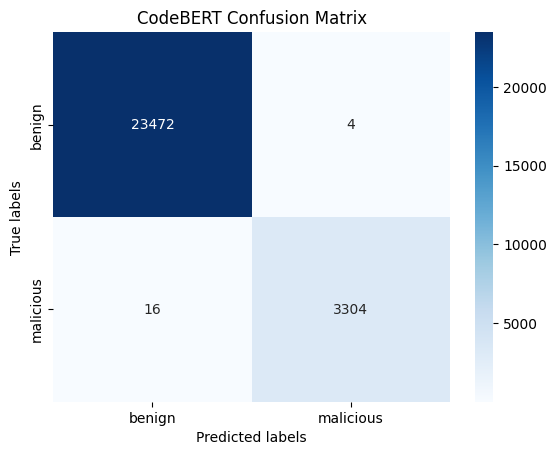

In [2]:
# plot confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax, fmt="g", cmap="Blues")
ax.set_xlabel("Predicted labels")
ax.set_ylabel("True labels")
ax.set_title("CodeBERT Confusion Matrix")
ax.xaxis.set_ticklabels(["benign", "malicious"])
ax.yaxis.set_ticklabels(["benign", "malicious"])
plt.savefig("../.readme/codebert_confusion_matrix.svg")
plt.show()

Accuracy: 0.999254
Precision: 0.998791
Recall: 0.995181
F1: 0.996982
ROC-AUC: 0.999980


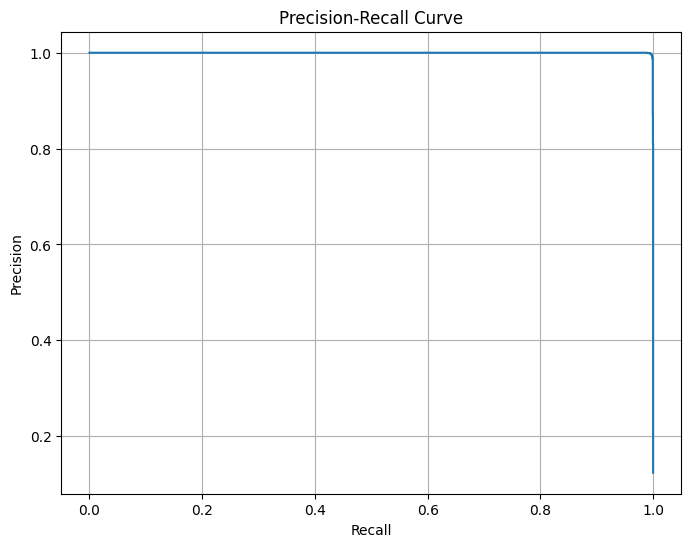

In [3]:
# Print metrics
print(f"Accuracy: {predictions.metrics['test_accuracy']:.6f}")
print(f"Precision: {predictions.metrics['test_precision']:.6f}")
print(f"Recall: {predictions.metrics['test_recall']:.6f}")
print(f"F1: {predictions.metrics['test_f1']:.6f}")
print(f"ROC-AUC: {predictions.metrics['test_roc_auc']:.6f}")

# Get precision and recall values
precision, recall, _ = precision_recall_curve(true_labels, positive_probs)

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.show()

In [4]:
# Compute predicted class labels
failures = np.where(pred_labels != true_labels)[0]

# Print failure cases
for i in range(len(pred_labels)):
    if pred_labels[i] != true_labels[i]:
        print(f"True label: {true_labels[i]}, Predicted label: {pred_labels[i]}")
        print(test_dataset.texts[i])
        print("-" * 100)

True label: 1, Predicted label: 0
iframe.contentwindow.location.constructor.prototype
----------------------------------------------------------------------------------------------------
True label: 1, Predicted label: 0
or (exists)
----------------------------------------------------------------------------------------------------
True label: 1, Predicted label: 0
\x23
----------------------------------------------------------------------------------------------------
True label: 0, Predicted label: 1
tables.sql\x00
----------------------------------------------------------------------------------------------------
True label: 1, Predicted label: 0
?
----------------------------------------------------------------------------------------------------
True label: 1, Predicted label: 0
1e100
----------------------------------------------------------------------------------------------------
True label: 1, Predicted label: 0
datasrc=#i datafld=c dataformatas=html
-------------------------

In [5]:
len(pred_labels)

26796

In [6]:
len(failures)

20

In [7]:
count_mailicious_total = 0
count_mailicious_failures = 0

count_benign_total = 0
count_benign_failures = 0

for i in range(len(pred_labels)):
    if pred_labels[i] != true_labels[i]:
        if true_labels[i] == 1:
            count_mailicious_failures += 1
        else:
            count_benign_failures += 1

    if true_labels[i] == 1:
        count_mailicious_total += 1
    else:
        count_benign_total += 1

print("Mailicious Total: ", count_mailicious_total)
print("Mailicious Failures: ", count_mailicious_failures)
print("Mailicious Failure Rate: ", count_mailicious_failures / count_mailicious_total)

print("-" * 100)

print("Benign Total: ", count_benign_total)
print("Benign Failures: ", count_benign_failures)
print("Benign Failure Rate: ", count_benign_failures / count_benign_total)

Mailicious Total:  3320
Mailicious Failures:  16
Mailicious Failure Rate:  0.004819277108433735
----------------------------------------------------------------------------------------------------
Benign Total:  23476
Benign Failures:  4
Benign Failure Rate:  0.0001703867779860283


In [8]:
num_samples = 1000
model.cuda()
model.eval()
start = time.time()
for i in tqdm(range(num_samples)):
    single_example = test_dataset[i]
    with torch.no_grad():
        logits = model(single_example["input_ids"].unsqueeze(0).to("cuda"), 
                       single_example["attention_mask"].unsqueeze(0).to("cuda"))[0]
        pred_label = torch.argmax(logits)

end = time.time()
print(f"Avg. GPU inference time: {(end - start) * 1000 / num_samples:.2f} ms")


100%|██████████| 1000/1000 [00:10<00:00, 93.64it/s]

Avg. GPU inference time: 10.68 ms


In [9]:
# measure inference time on CPU
model.cpu()
model.eval()
start = time.time()
for i in tqdm(range(num_samples)):
    single_example = test_dataset[i]
    with torch.no_grad():
        logits = model(single_example["input_ids"].unsqueeze(0), 
                       single_example["attention_mask"].unsqueeze(0))[0]
        pred_label = torch.argmax(logits)

end = time.time()
print(f"Avg. CPU inference time: {(end - start) * 1000 / num_samples:.2f} ms")

100%|██████████| 1000/1000 [04:41<00:00,  3.55it/s]

Avg. CPU inference time: 281.92 ms
